In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [17]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [18]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [19]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [20]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [21]:
input_size = 784
output_size = 10

In [22]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [23]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [24]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [336]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
        self.scaler = nn.Parameter(torch.Tensor([1.0]))
        
    def forward(self, x):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        
        ### normalize similar to UMAP
        dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        
        dists = dists/dists.std(dim=1, keepdim=True)
        dists = torch.exp(-dists*self.scaler)
        
        return dists

In [337]:
dt = DistanceTransform(784, 784)

In [338]:
dists = dt(torch.randn(2, 784))

In [339]:
dists.shape

torch.Size([2, 784])

In [340]:
model = nn.Sequential(
                DistanceTransform(784, 785),
#                 nn.LayerNorm(785),
                nn.Linear(785, 200),
                nn.BatchNorm1d(200),
                nn.LeakyReLU(),
                nn.Linear(200, 50),
                nn.BatchNorm1d(50),
                nn.LeakyReLU(),
                nn.Linear(50, 10))
model.to(device)

Sequential(
  (0): DistanceTransform()
  (1): Linear(in_features=785, out_features=200, bias=True)
  (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=200, out_features=50, bias=True)
  (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Linear(in_features=50, out_features=10, bias=True)
)

In [341]:
optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.0003, weight_decay=1e-15)
criterion = nn.CrossEntropyLoss()

In [342]:
index = 0
train_accs, test_accs = [], []
model.train()
for epoch in tqdm(list(range(40))):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:0.3121315836906433


  2%|▎         | 1/40 [00:03<02:24,  3.71s/it]

Train Acc:83.33%, Test Acc:85.35%

Epoch: 1:0,  Loss:0.5740612149238586


  5%|▌         | 2/40 [00:07<02:22,  3.74s/it]

Train Acc:87.62%, Test Acc:86.73%

Epoch: 2:0,  Loss:0.2148779332637787


  8%|▊         | 3/40 [00:11<02:19,  3.76s/it]

Train Acc:88.96%, Test Acc:87.01%

Epoch: 3:0,  Loss:0.21733969449996948


 10%|█         | 4/40 [00:15<02:15,  3.77s/it]

Train Acc:90.03%, Test Acc:87.70%

Epoch: 4:0,  Loss:0.30548685789108276


 12%|█▎        | 5/40 [00:18<02:12,  3.77s/it]

Train Acc:90.81%, Test Acc:87.99%

Epoch: 5:0,  Loss:0.18854713439941406


 15%|█▌        | 6/40 [00:22<02:07,  3.74s/it]

Train Acc:91.51%, Test Acc:88.06%

Epoch: 6:0,  Loss:0.1525152027606964


 18%|█▊        | 7/40 [00:26<02:03,  3.73s/it]

Train Acc:91.95%, Test Acc:88.20%

Epoch: 7:0,  Loss:0.17967838048934937


 20%|██        | 8/40 [00:29<01:59,  3.72s/it]

Train Acc:92.62%, Test Acc:88.56%

Epoch: 8:0,  Loss:0.1536894291639328


 22%|██▎       | 9/40 [00:33<01:55,  3.71s/it]

Train Acc:93.16%, Test Acc:88.66%

Epoch: 9:0,  Loss:0.06577574461698532


 25%|██▌       | 10/40 [00:37<01:51,  3.71s/it]

Train Acc:93.65%, Test Acc:88.72%

Epoch: 10:0,  Loss:0.19157670438289642


 28%|██▊       | 11/40 [00:41<01:47,  3.72s/it]

Train Acc:94.21%, Test Acc:88.72%

Epoch: 11:0,  Loss:0.1982671171426773


 30%|███       | 12/40 [00:44<01:44,  3.73s/it]

Train Acc:94.51%, Test Acc:88.19%

Epoch: 12:0,  Loss:0.06288096308708191


 32%|███▎      | 13/40 [00:48<01:40,  3.71s/it]

Train Acc:94.91%, Test Acc:88.64%

Epoch: 13:0,  Loss:0.13260236382484436


 35%|███▌      | 14/40 [00:52<01:36,  3.73s/it]

Train Acc:95.35%, Test Acc:88.40%

Epoch: 14:0,  Loss:0.08584803342819214


 38%|███▊      | 15/40 [00:55<01:33,  3.74s/it]

Train Acc:95.46%, Test Acc:89.14%

Epoch: 15:0,  Loss:0.16059324145317078


 40%|████      | 16/40 [00:59<01:29,  3.75s/it]

Train Acc:95.89%, Test Acc:88.79%

Epoch: 16:0,  Loss:0.13377518951892853


 42%|████▎     | 17/40 [01:03<01:25,  3.73s/it]

Train Acc:96.13%, Test Acc:89.22%

Epoch: 17:0,  Loss:0.09416171163320541


 45%|████▌     | 18/40 [01:07<01:22,  3.73s/it]

Train Acc:96.24%, Test Acc:89.13%

Epoch: 18:0,  Loss:0.05345658212900162


 48%|████▊     | 19/40 [01:10<01:18,  3.72s/it]

Train Acc:96.53%, Test Acc:88.72%

Epoch: 19:0,  Loss:0.06015738099813461


 50%|█████     | 20/40 [01:14<01:14,  3.74s/it]

Train Acc:96.69%, Test Acc:88.79%

Epoch: 20:0,  Loss:0.21252229809761047


 52%|█████▎    | 21/40 [01:18<01:11,  3.75s/it]

Train Acc:96.98%, Test Acc:88.98%

Epoch: 21:0,  Loss:0.058063678443431854


 55%|█████▌    | 22/40 [01:22<01:07,  3.75s/it]

Train Acc:97.09%, Test Acc:88.56%

Epoch: 22:0,  Loss:0.05685444176197052


 57%|█████▊    | 23/40 [01:26<01:04,  3.78s/it]

Train Acc:97.13%, Test Acc:88.83%

Epoch: 23:0,  Loss:0.09939855337142944


 60%|██████    | 24/40 [01:29<01:00,  3.77s/it]

Train Acc:97.37%, Test Acc:88.43%

Epoch: 24:0,  Loss:0.11276864260435104


 62%|██████▎   | 25/40 [01:33<00:56,  3.76s/it]

Train Acc:97.41%, Test Acc:88.29%

Epoch: 25:0,  Loss:0.04465131461620331


 65%|██████▌   | 26/40 [01:37<00:52,  3.75s/it]

Train Acc:97.66%, Test Acc:88.52%

Epoch: 26:0,  Loss:0.02999715320765972


 68%|██████▊   | 27/40 [01:40<00:48,  3.73s/it]

Train Acc:97.67%, Test Acc:88.49%

Epoch: 27:0,  Loss:0.02535800263285637


 70%|███████   | 28/40 [01:44<00:44,  3.75s/it]

Train Acc:97.78%, Test Acc:88.89%

Epoch: 28:0,  Loss:0.054643381386995316


 72%|███████▎  | 29/40 [01:48<00:41,  3.75s/it]

Train Acc:97.78%, Test Acc:88.42%

Epoch: 29:0,  Loss:0.1085183396935463


 75%|███████▌  | 30/40 [01:52<00:37,  3.75s/it]

Train Acc:97.99%, Test Acc:88.52%

Epoch: 30:0,  Loss:0.05548835173249245


 78%|███████▊  | 31/40 [01:55<00:33,  3.74s/it]

Train Acc:97.96%, Test Acc:88.91%

Epoch: 31:0,  Loss:0.005901871714740992


 80%|████████  | 32/40 [01:59<00:29,  3.74s/it]

Train Acc:98.07%, Test Acc:88.70%

Epoch: 32:0,  Loss:0.04890795052051544


 82%|████████▎ | 33/40 [02:03<00:26,  3.74s/it]

Train Acc:98.27%, Test Acc:88.72%

Epoch: 33:0,  Loss:0.06398676335811615


 85%|████████▌ | 34/40 [02:07<00:22,  3.75s/it]

Train Acc:98.12%, Test Acc:88.83%

Epoch: 34:0,  Loss:0.012963137589395046


 88%|████████▊ | 35/40 [02:10<00:18,  3.73s/it]

Train Acc:98.29%, Test Acc:89.01%

Epoch: 35:0,  Loss:0.0771908313035965


 90%|█████████ | 36/40 [02:14<00:14,  3.71s/it]

Train Acc:98.35%, Test Acc:88.71%

Epoch: 36:0,  Loss:0.03162826970219612


 92%|█████████▎| 37/40 [02:18<00:11,  3.73s/it]

Train Acc:98.44%, Test Acc:88.82%

Epoch: 37:0,  Loss:0.07023712992668152


 95%|█████████▌| 38/40 [02:22<00:07,  3.73s/it]

Train Acc:98.45%, Test Acc:88.32%

Epoch: 38:0,  Loss:0.021399326622486115


 98%|█████████▊| 39/40 [02:25<00:03,  3.72s/it]

Train Acc:98.57%, Test Acc:89.20%

Epoch: 39:0,  Loss:0.1077868863940239


100%|██████████| 40/40 [02:29<00:00,  3.74s/it]

Train Acc:98.56%, Test Acc:88.71%

	-> MAX Train Acc 98.57166666666667 ; Test Acc 89.22


In [38]:
# -> MAX Train Acc 87.678 ; Test Acc 85.87  ### after distance transformation
# -> MAX Train Acc 98.1367 ; Test Acc 89.22 ### after distance normalization
# -> MAX Train Acc 98.6317 ; Test Acc 89.36 ### after distance normalization and -ve exp
# -> MAX Train Acc 97.255 ; Test Acc 89.01  ### normal nn

In [ ]:
### with 20 input units
-> MAX Train Acc 90.65833333333333 ; Test Acc 87.45 ## 20 centroids
-> MAX Train Acc 92.34166666666667 ; Test Acc 87.54 ## 20 linear transforms

In [345]:
model.eval()
dists = model[0](train_dataset[np.random.randint(0, len(train_dataset), 50)][0].to(device))
# dists = model[1](dists)
model.train()
dists.shape

torch.Size([50, 785])

In [346]:
dists.mean()

tensor(0.0694, device='cuda:0', grad_fn=<MeanBackward0>)

In [347]:
dists.std()

tensor(0.0904, device='cuda:0', grad_fn=<StdBackward>)

In [350]:
model[0].scaler

Parameter containing:
tensor([1.0543], device='cuda:0', requires_grad=True)

## UMAP - from library

In [351]:
import umap

In [352]:
embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.01, spread=1)

In [353]:
# # indx = np.random.randint(0, len(train_dataset), 785)
# # centers = train_data[indx].cpu().numpy()
# # lbls = train_label_[indx]

# centers = train_data.cpu().numpy()
# lbls = train_label_

# embedding = embed.fit_transform(centers)
# # centers.shape

In [354]:
# plt.figure(figsize=(9,6))
# plt.scatter(embedding[:,0], embedding[:, 1], c=lbls, cmap="tab10", s=0.1)

In [355]:
centers = model[0].centers.data.cpu().numpy()
embedding = embed.fit_transform(centers)

In [356]:
# plt.scatter(embedding[:,0], embedding[:, 1])

In [357]:
i = 0

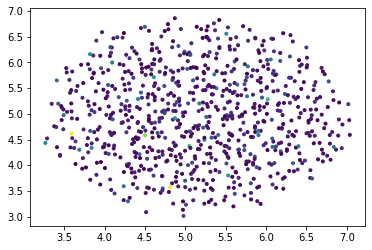

In [401]:
activ = dists.data.cpu()[i]
# activ = activ - activ.min()
# activ = torch.exp(-activ)
plt.scatter(embedding[:,0], embedding[:, 1], c=activ, marker=".")#, cmap="Greys")
i += 1

## TSNE

In [247]:
from sklearn.manifold import TSNE

In [248]:
tsne = TSNE(n_components=2)
embt = tsne.fit_transform(centers)

In [249]:
embt

array([[-12.275328 , -35.70522  ],
       [  2.3254476,   4.925307 ],
       [ -9.32395  ,  23.412096 ],
       ...,
       [ 23.207048 , -18.275816 ],
       [ 24.64131  ,   8.594247 ],
       [-26.30702  ,  12.419894 ]], dtype=float32)

In [301]:
i = 0

34


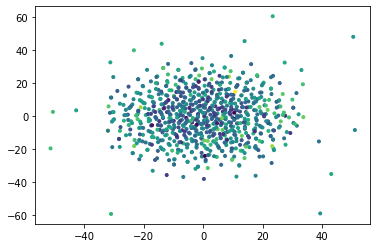

In [335]:
print(i := i+1)
activ = dists.data.cpu()[i]
activ = activ - activ.min()
activ = torch.exp(-activ)
plt.scatter(embt[:,0], embt[:, 1], c=activ, marker=".")